In [60]:
import numpy as np
import os
import pandas

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout 
from keras.callbacks import ModelCheckpoint 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import model_from_json
from keras.constraints import maxnorm
from keras.optimizers import SGD 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
from config import csv_config as config
dataset_path = config.DATASET_PATH

In [62]:
seed = 7
np.random.seed(seed)

In [63]:
data = pandas.read_csv(dataset_path)
print(data.shape)
print(data.head())

(768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [65]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [66]:
data.groupby("Outcome").size()

Outcome
0    500
1    268
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023DBFB3E860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000023DBFC5D278>]], dtype=object)

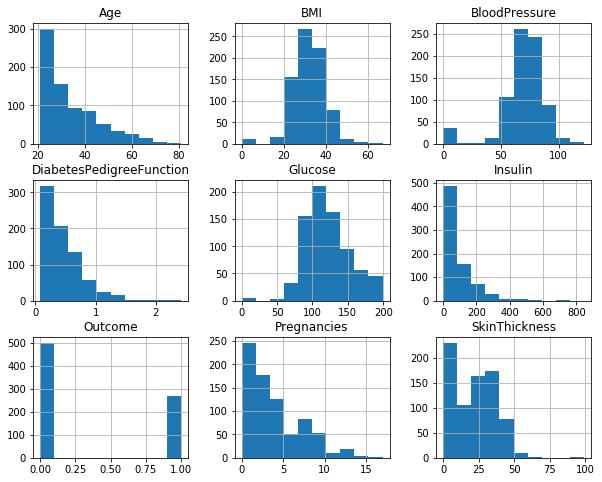

In [67]:
data.hist(figsize=(10,8))

Pregnancies                    AxesSubplot(0.125,0.657941;0.227941x0.222059)
Glucose                     AxesSubplot(0.398529,0.657941;0.227941x0.222059)
BloodPressure               AxesSubplot(0.672059,0.657941;0.227941x0.222059)
SkinThickness                  AxesSubplot(0.125,0.391471;0.227941x0.222059)
Insulin                     AxesSubplot(0.398529,0.391471;0.227941x0.222059)
BMI                         AxesSubplot(0.672059,0.391471;0.227941x0.222059)
DiabetesPedigreeFunction          AxesSubplot(0.125,0.125;0.227941x0.222059)
Age                            AxesSubplot(0.398529,0.125;0.227941x0.222059)
Outcome                        AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

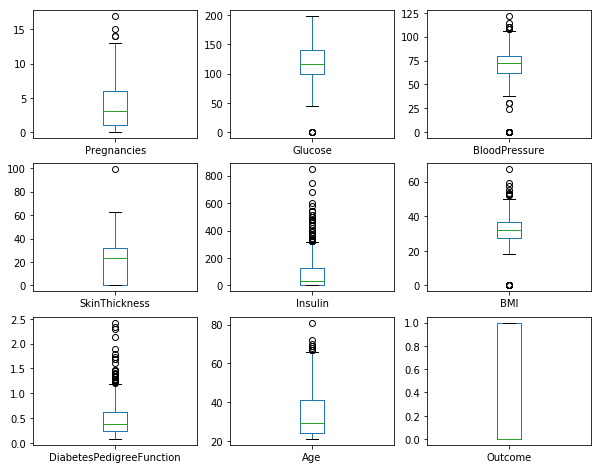

In [68]:
data.plot(kind= 'box' , subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,8))

In [69]:
data_in = data[data.apply(lambda x: np.abs(x - x.mean()) / x.std() <= 3).all(axis=1)]

In [70]:
data_in.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0


In [71]:
data_in.groupby("Outcome").size()

Outcome
0    461
1    227
dtype: int64

Pregnancies                    AxesSubplot(0.125,0.657941;0.227941x0.222059)
Glucose                     AxesSubplot(0.398529,0.657941;0.227941x0.222059)
BloodPressure               AxesSubplot(0.672059,0.657941;0.227941x0.222059)
SkinThickness                  AxesSubplot(0.125,0.391471;0.227941x0.222059)
Insulin                     AxesSubplot(0.398529,0.391471;0.227941x0.222059)
BMI                         AxesSubplot(0.672059,0.391471;0.227941x0.222059)
DiabetesPedigreeFunction          AxesSubplot(0.125,0.125;0.227941x0.222059)
Age                            AxesSubplot(0.398529,0.125;0.227941x0.222059)
Outcome                        AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

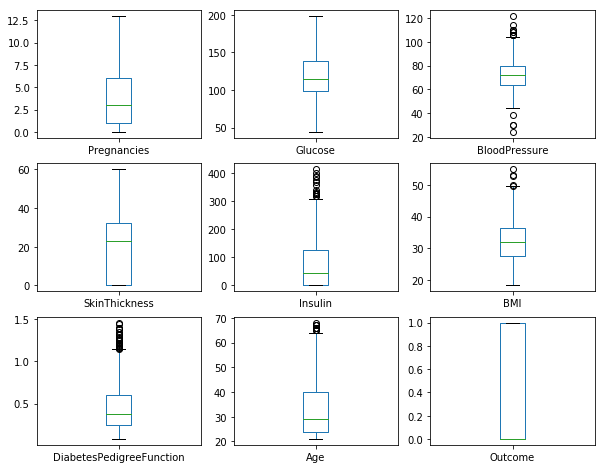

In [72]:
data_in.plot(kind= 'box' , subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,8))

In [73]:
data_out = data.loc[data.index.difference(data_in.index)]

In [75]:
data_out.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,0,137,40,35,168,43.1,2.288,33,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1
13,1,189,60,23,846,30.1,0.398,59,1


In [76]:
data_out.groupby("Outcome").size()

Outcome
0    39
1    41
dtype: int64

In [77]:
fields = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for field in fields :
    print('field %s : num 0-entries: %d' % (field, len(data.loc[ data[field] == 0, field ])))

field Glucose : num 0-entries: 5
field BloodPressure : num 0-entries: 35
field SkinThickness : num 0-entries: 227
field Insulin : num 0-entries: 374
field BMI : num 0-entries: 11


In [78]:
def replace_zero_field(data, field):
    nonzero_vals = data.loc[data[field] != 0, field]
    avg = nonzero_vals.median()
    length = len(data.loc[ data[field] == 0, field])   # num of 0-entries
    data.loc[ data[field] == 0, field ] = avg
    print('Field: %s; fixed %d entries with value: %.3f' % (field,length, avg))

for field in fields :
    replace_zero_field(data,field)
print()
for field in fields :
    print('Field %s : num 0-entries: %d' % (field, len(data.loc[ data[field] == 0, field ])))

Field: Glucose; fixed 5 entries with value: 117.000
Field: BloodPressure; fixed 35 entries with value: 72.000
Field: SkinThickness; fixed 227 entries with value: 29.000
Field: Insulin; fixed 374 entries with value: 125.000
Field: BMI; fixed 11 entries with value: 32.300

Field Glucose : num 0-entries: 0
Field BloodPressure : num 0-entries: 0
Field SkinThickness : num 0-entries: 0
Field Insulin : num 0-entries: 0
Field BMI : num 0-entries: 0


In [80]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [81]:
fields = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for field in fields :
    print('field %s : num 0-entries: %d' % (field, len(data.loc[ data[field] == 0, field ])))

field Glucose : num 0-entries: 0
field BloodPressure : num 0-entries: 0
field SkinThickness : num 0-entries: 0
field Insulin : num 0-entries: 0
field BMI : num 0-entries: 0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023DC15A0630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000023DC14CFAC8>]], dtype=object)

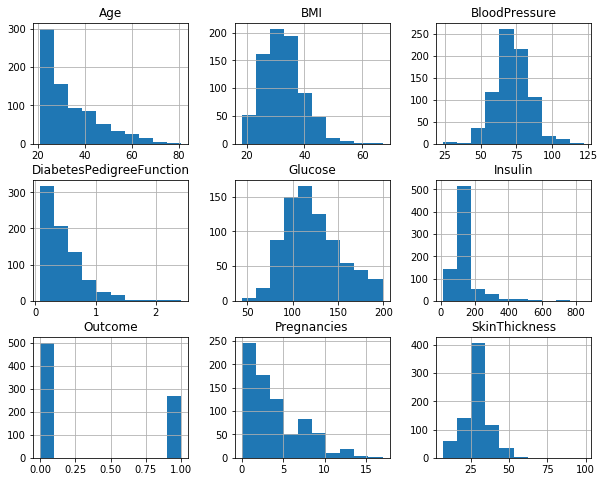

In [82]:
data.hist(figsize=(10,8))

Pregnancies                    AxesSubplot(0.125,0.657941;0.227941x0.222059)
Glucose                     AxesSubplot(0.398529,0.657941;0.227941x0.222059)
BloodPressure               AxesSubplot(0.672059,0.657941;0.227941x0.222059)
SkinThickness                  AxesSubplot(0.125,0.391471;0.227941x0.222059)
Insulin                     AxesSubplot(0.398529,0.391471;0.227941x0.222059)
BMI                         AxesSubplot(0.672059,0.391471;0.227941x0.222059)
DiabetesPedigreeFunction          AxesSubplot(0.125,0.125;0.227941x0.222059)
Age                            AxesSubplot(0.398529,0.125;0.227941x0.222059)
Outcome                        AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

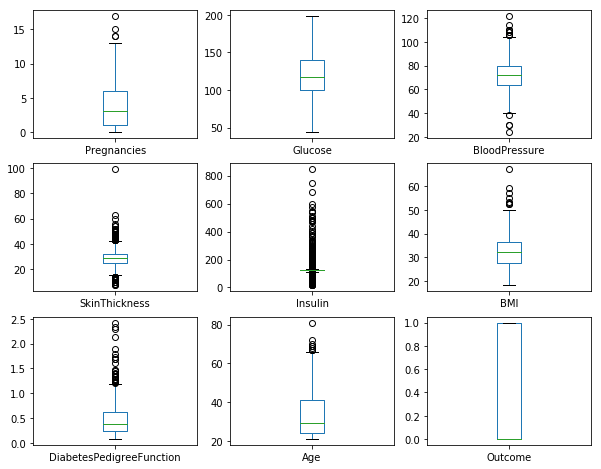

In [83]:
data.plot(kind= 'box' , subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,8))

In [84]:
data_in = data[data.apply(lambda x: np.abs(x - x.mean()) / x.std() <= 3).all(axis=1)]
data_out = data.loc[data.index.difference(data_in.index)]

In [85]:
data_in.groupby("Outcome").size()

Outcome
0    476
1    242
dtype: int64

In [86]:
data_out.groupby("Outcome").size()

Outcome
0    24
1    26
dtype: int64

In [87]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [88]:
data_arr = data.values
X = data_arr[:,0:8]
Y = data_arr[:,8]
print(data_arr.shape)
print(X.shape)
print(Y.shape)

(768, 9)
(768, 8)
(768,)


In [89]:
select_top_5 = SelectKBest(score_func=chi2, k = 5)

In [90]:
fit = select_top_5.fit(X,Y)
features = fit.transform(X)

In [91]:
features[0:5]

array([[   6. ,  148. ,  125. ,   33.6,   50. ],
       [   1. ,   85. ,  125. ,   26.6,   31. ],
       [   8. ,  183. ,  125. ,   23.3,   32. ],
       [   1. ,   89. ,   94. ,   28.1,   21. ],
       [   0. ,  137. ,  168. ,   43.1,   33. ]])

In [92]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [37]:
X_features = pandas.DataFrame(data = features, columns = ["Pregnancies","Glucose","Insulin","BMI","Age"])
X_features.head()

,Pregnancies,Glucose,Insulin,BMI,Age
0,1.0,90.0,43.0,27.2,24.0
1,7.0,181.0,192.0,35.9,51.0
2,13.0,152.0,29.0,26.8,43.0
3,6.0,93.0,64.0,28.7,23.0
4,6.0,125.0,125.0,27.6,49.0


In [98]:
X1 = preprocessing.scale(X)

In [53]:
[sorted_idx]

[array([28,  2, 98, 52, 14], dtype=int64)]

In [93]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [94]:
from sklearn import decomposition

In [95]:
pca = decomposition.PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [96]:
X_prime = pca.fit_transform(X1)
X_prime.shape

(768, 2)

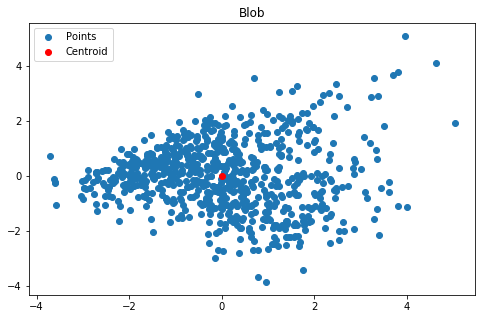

In [97]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=1)
kmeans.fit(X_prime)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
 n_clusters=1, n_init=10, n_jobs=1, precompute_distances='auto',
 random_state=None, tol=0.0001, verbose=0)

import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Blob")
ax.scatter(X_prime[:, 0], X_prime[:, 1], label='Points')
ax.scatter(kmeans.cluster_centers_[:, 0],kmeans.cluster_centers_[:, 1], label='Centroid',color='r')
ax.legend()

In [99]:
distances = kmeans.transform(X_prime)
sorted_idx = np.argsort(distances.ravel())[::-1][:10]

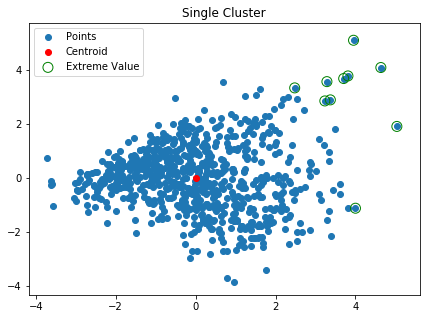

In [100]:
f, ax = plt.subplots(figsize=(7, 5))
ax.set_title("Single Cluster")
ax.scatter(X_prime[:, 0], X_prime[:, 1], label='Points')
ax.scatter(kmeans.cluster_centers_[:, 0],kmeans.cluster_centers_[:, 1],label='Centroid', color='r')
ax.scatter(X_prime[sorted_idx][:, 0], X_prime[sorted_idx][:, 1],label='Extreme Value', edgecolors='g',facecolors='none', s=100)
ax.legend(loc='best')

In [101]:
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap

In [102]:
pca = PCA(n_components = 2).fit_transform(X_prime)
tsne = TSNE(learning_rate=200).fit_transform(X_prime)

MDS = MDS(n_components = 2).fit_transform(X_prime)
ISO = Isomap(n_components = 2).fit_transform(X_prime)

Text(0.5,1,'ISO')

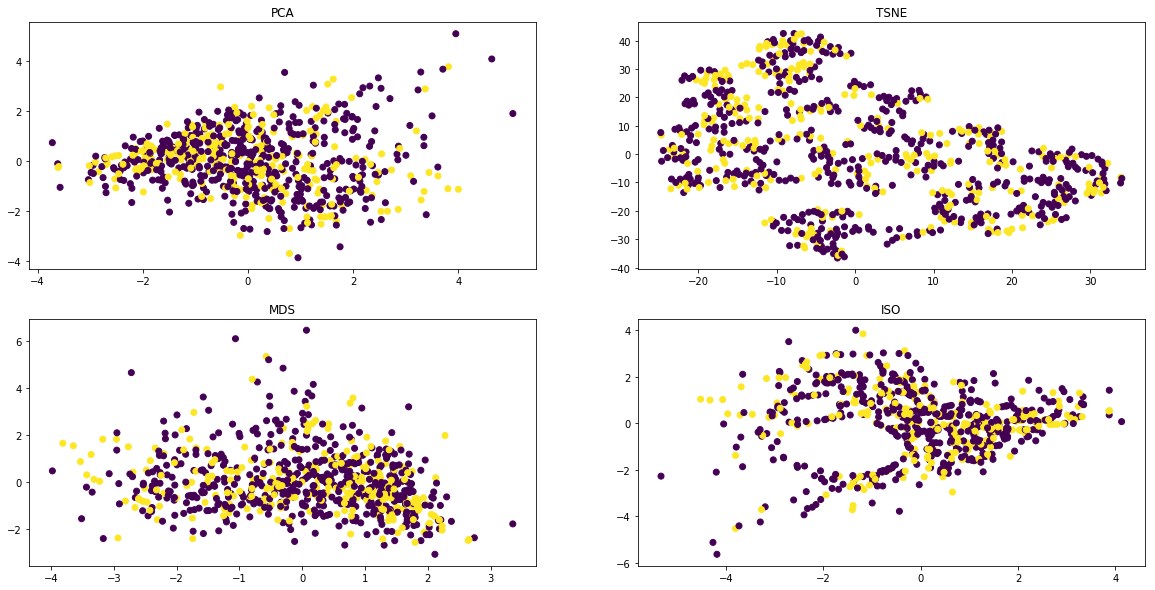

In [104]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('PCA')
plt.scatter(pca [:, 0], pca [:, 1], c=Y)

plt.subplot(222)
plt.scatter(tsne[:, 0], tsne[:, 1], c=Y)
plt.title('TSNE')

plt.subplot(223)
plt.scatter(MDS[:, 0], MDS[:, 1], c=Y)
plt.title('MDS')

plt.subplot(224)
plt.scatter(ISO[:, 0], ISO[:, 1], c=Y)
plt.title('ISO')